In [1]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Simple Exponential Smoothing models
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [2]:
# Read data
df = pd.read_csv('Apple_clean.csv')
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200
...,...,...,...,...,...,...,...
3977,2025-10-23,259.940002,260.619995,258.010010,259.579987,259.579987,32754900
3978,2025-10-24,261.190002,264.130005,259.179993,262.820007,262.820007,38253700
3979,2025-10-27,264.880005,269.119995,264.649994,268.809998,268.809998,44888200
3980,2025-10-28,268.989990,269.890015,268.149994,269.000000,269.000000,41461500


In [9]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as index value
df.set_index('Date', inplace=True)


In [10]:
# Select the 'Close' column
df_Close = df[['Close']]


In [11]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))


In [12]:
# Split the data into training, validation and test dataset in a ratio of 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[:train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]


In [13]:
best_alpha = None
best_mse = float('inf')
best_rmse = None
best_mape = None
best_msle = None
best_y_pred_val = None


In [15]:
import warnings
from statsmodels.tools.sm_exceptions import EstimationWarning

# (tùy chọn) chặn EstimationWarning toàn cục nếu muốn:
warnings.filterwarnings("ignore", category=EstimationWarning)

best_alpha = None
best_mse = float('inf')
best_rmse = None
best_mape = None
best_msle = None
best_y_pred_val = None

for alpha in np.arange(0.1, 1, 0.1):
    alpha = round(alpha, 1)

    # make history 1-D list of floats
    history = train_data.reshape(-1).tolist()  # train_data thường shape (n,1) => flatten
    y_pred_val = []

    for i in val_data:
        # create model on 1-D series
        model = SimpleExpSmoothing(history)
        # pass optimized=False because smoothing_level fixed
        model_fit = model.fit(smoothing_level=alpha, optimized=False)
        prediction = model_fit.forecast()
        y_pred_val.append(prediction[0])
        # append the actual next observation (float) to history
        history.append(float(i.reshape(-1)[0]))  # i may be (1,) or (1,1)

    # inverse transform and compute metrics
    val_data_temp = val_data.reshape(-1, 1)
    y_pred_val_arr = np.array(y_pred_val).reshape(-1, 1)

    val_data_inv = scaler.inverse_transform(val_data_temp)
    y_pred_val_inv = scaler.inverse_transform(y_pred_val_arr)

    mape = mean_absolute_percentage_error(val_data_inv, y_pred_val_inv)
    mse = mean_squared_error(val_data_inv, y_pred_val_inv)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(val_data_inv, y_pred_val_inv)

    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse
        best_rmse = rmse
        best_mape = mape
        best_msle = msle
        best_y_pred_val = y_pred_val_inv


In [16]:
print("Best alpha:", best_alpha)


Best alpha: 0.9


In [17]:
print("MAPE on Validate dataset:", best_mape)
print("RMSE on Validate dataset:", best_rmse)
print("MSLE on Validate dataset:", best_msle)


MAPE on Validate dataset: 0.013710180218867647
RMSE on Validate dataset: 2.7083152962456243
MSLE on Validate dataset: 0.00032021896293605846


In [18]:
y_pred = []
# start history as train + val flattened
history = np.concatenate([train_data, val_data]).reshape(-1).tolist()

for i in test_data:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    prediction = model_fit.forecast()
    y_pred.append(prediction[0])
    # append actual test observation into history
    history.append(float(i.reshape(-1)[0]))

# inverse transform
y_pred_inv = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


In [19]:
test_data_inv = scaler.inverse_transform(test_data)
y_pred_inv = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(test_data_inv, y_pred_inv)
test_mse = mean_squared_error(test_data_inv, y_pred_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_data_inv, y_pred_inv)

print("MAPE on Test dataset:", test_mape)
print("RMSE on Test dataset:", test_rmse)
print("MSLE on Test dataset:", test_msle)


MAPE on Test dataset: 0.012288498301990441
RMSE on Test dataset: 3.374519186948419
MSLE on Test dataset: 0.00030935857272139394


In [20]:
# Get the last date
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices for the next 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()


In [21]:
y_next_30_days = []
# history includes train + val + test, flattened
history = np.concatenate([train_data, val_data, test_data]).reshape(-1).tolist()

for _ in range(30):
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = model_fit.forecast()[0]
    y_next_30_days.append(pred)
    # append predicted (already scaled) into history for multi-step forecasting
    history.append(float(pred))

y_next_30_days_arr = np.array(y_next_30_days).reshape(-1,1)
y_next_30_days_inv = scaler.inverse_transform(y_next_30_days_arr)


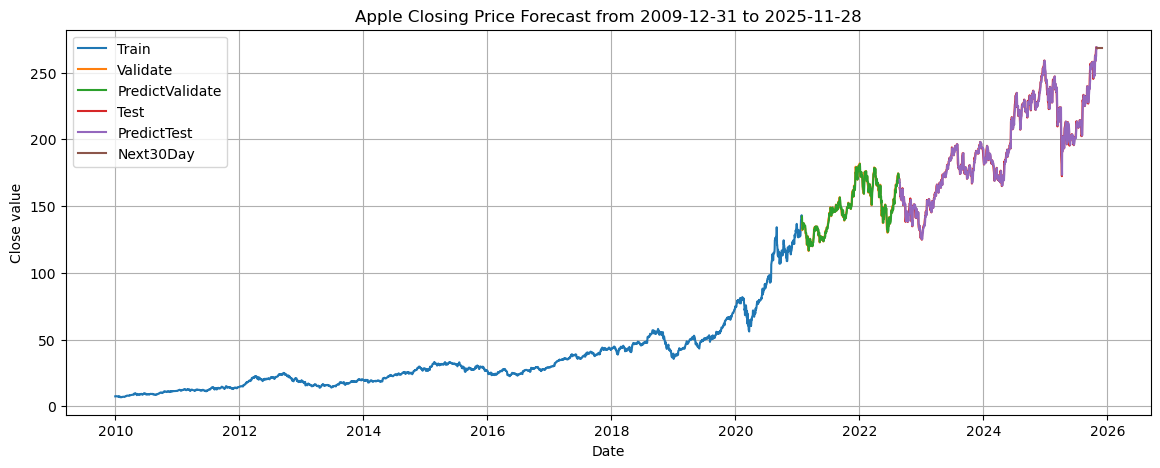

In [22]:
plt.figure(figsize=(14,5))

# Plot Train
plt.plot(df.index[:train_size], scaler.inverse_transform(np.array(train_data).reshape(-1, 1)), label='Train')

# Plot Validation
plt.plot(df.index[train_size:train_size + val_size], scaler.inverse_transform(np.array(val_data).reshape(-1, 1)), label='Validate')

# Plot Predicted Validation
plt.plot(df.index[train_size:train_size + val_size], best_y_pred_val, label='PredictValidate')

# Plot Test
plt.plot(df.index[train_size + val_size:], scaler.inverse_transform(np.array(test_data).reshape(-1, 1)), label='Test')

# Plot Predicted Test
plt.plot(df.index[train_size + val_size:], y_pred_inv, label='PredictTest')

# Plot Next 30 Days Forecast
plt.plot(index_next_30_days, y_next_30_days_inv, label='Next30Day')

plt.grid()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close value")
plt.title(f"Apple Closing Price Forecast from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.savefig("EST_712_Apple.png")
plt.show()
